In [1]:
# How to generate random arbitrary state
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
from numpy import *
import numpy as np
from numpy import linalg as LA 
import matplotlib.pyplot as plt

# Find time elapsed
import time

# Find error vector based on circuit measurement results
import scipy.optimize

In [2]:
# Build circuit

def toffoli_test(err=[0,0,0], plot=True, save=False, input_str=range(8)):
    err = array(err) + 1
    circ = Circuit(3)
    circ.Y(0, -pi/2).Y(1, -pi/2).X(1, -pi/4).X(2,pi/4).XX(0,2,pi/4*err[1]).XX(1,2,pi/4*err[2]).Y(1,pi/2).X(1,-pi/2).XX(0,1,-pi/2)
    circ.Y(1,pi/2).X(1,-pi/4).XX(1,2,pi/4*err[2]).Y(1,-pi/2).X(1,-pi/2).XX(0,1,-pi/2*err[0]).X(0,3*pi/4).Y(0,pi/2)

    circ.init_state = zero_state(3)
    
    measured_probs = []

    for i in input_str:
        circ.init_state = zero_state(3)
        circ.init_state[0] = 0
        circ.init_state[i] = 1

        final_state = circ.compute()[0]
        
        if plot:
            state_prob_plot(final_state, title=f'Input state = {i}', save=save)
        
        measured_probs.append(abs(final_state) ** 2)
    
    # Measured state probabilities for all inputs
    return measured_probs

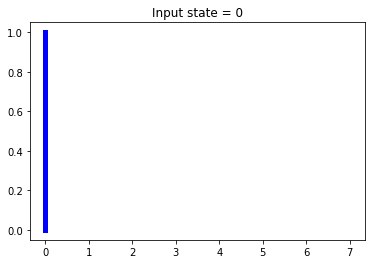

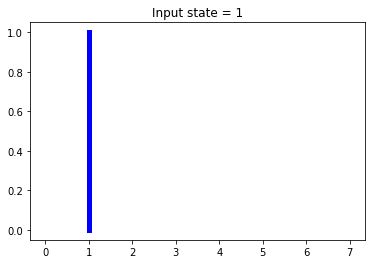

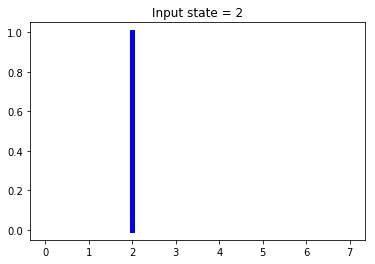

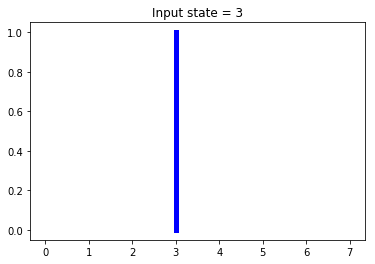

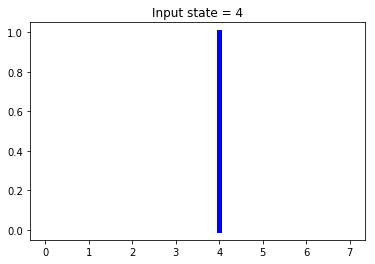

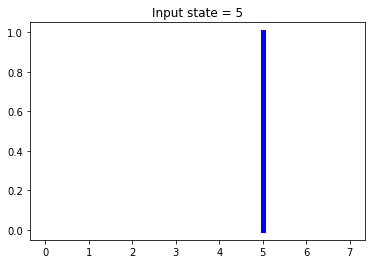

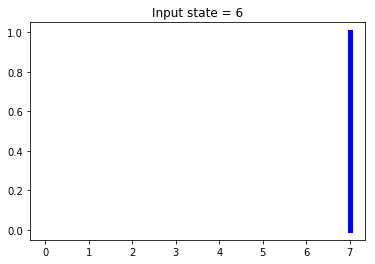

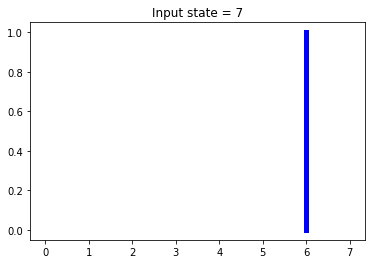

In [3]:
_ = toffoli_test([0,0,0])

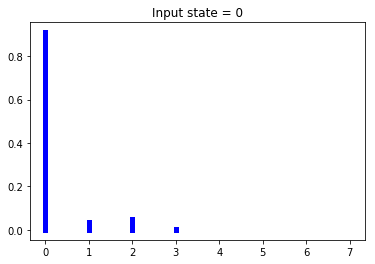

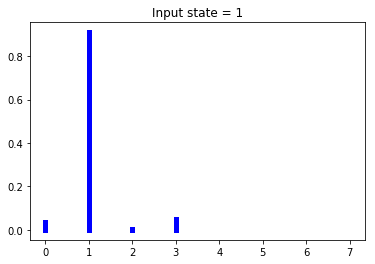

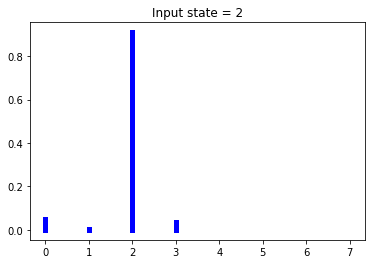

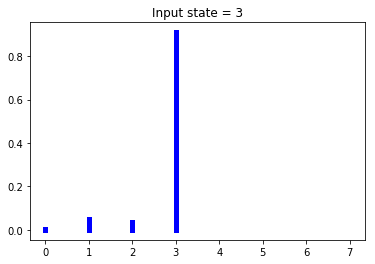

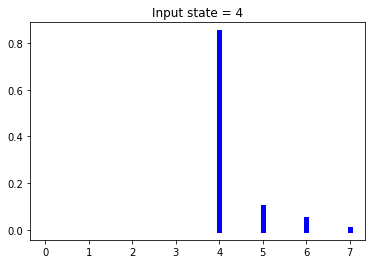

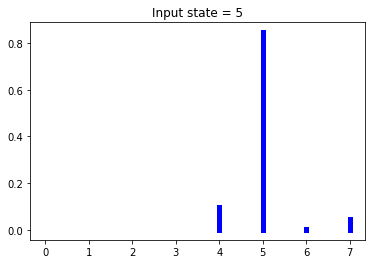

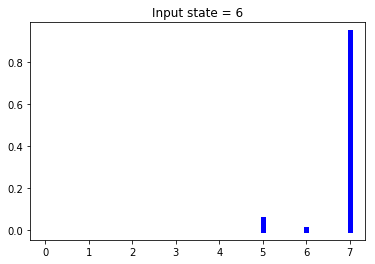

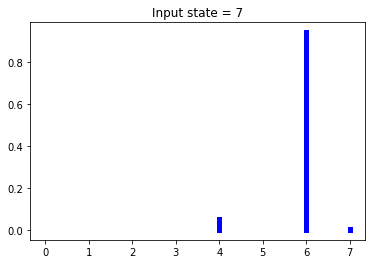

In [4]:
_ = toffoli_test([0.3, 0.5, -0.17])

In [5]:
# Let's say our 2-qubit gates have an over-rotation 'vector'
err = [0.23, -0.33, -0.09]

# This should be the output state probabilities that we measure
measured_probs = toffoli_test(err, plot=False)

# We want to try to guess what the error is based on the simulated outputs
# See diagrams above
inputs = [1,2,5,6]
outputs = { 1: [0,2,3], 2: [0,1,3], 5: [4,6,7], 6: [4,5,7]}

lowest_dev = 999
guess = None

start = time.time()

x = 11
all_devs = zeros([x, x, x]) + 999

# The 'deviation' function (to be minimized)
# x1 is the over-rotation 'vector'
def dev(x1):
    current_dev = 0
    current_measured_probs = toffoli_test(x1, plot=False)

#             print(current_measured_probs)
#             print(measured_probs)

    for i_str in inputs:
        for o_str in outputs[i_str]:
            current_dev += (current_measured_probs[i_str][o_str] - measured_probs[i_str][o_str]) ** 2

# Lowest 10
#             if current_dev < lowest_dev:
#                 guess = [ -0.5 + i * 0.1, -0.5 + j * 0.1, -0.5 + k * 0.1 ]
#                 lowest_dev = current_dev
    
    return current_dev

# Coarse grain sweep (with 0.1 increments)
for i in range(x):
    for j in range(x):
        for k in range(x):
            x1 = [ -0.5 + i * 0.1, -0.5 + j * 0.1, -0.5 + k * 0.1 ]
            all_devs[i][j][k] = dev(x1)


def sort_array(all_devs, x, lowest=10):
    
    # Sort the indices for the lowest 10 deviations 
    # We have to flatten multi-index array first
    indices = all_devs.flatten().argsort()[:lowest]
    
    multi_indices = []
    devs = []
    
    for z in range(lowest):
        
        # Compute digits of a number with base x. No method in numpy offers this, unfortunately
        s0 = indices[z]
        k = int(s0 % x)
        s1 = (s0 - s0 % x) / x
        j = int(s1 % x)
        s2 = (s1 - s1 % x) / x
        i = int(s2 % x)

        multi_indices.append(array([ -0.5 + i * 0.1, -0.5 + j * 0.1, -0.5 + k * 0.1 ]))
        devs.append(all_devs[i][j][k])

    return multi_indices, devs

lowest = 10
multi_indices, devs = sort_array(all_devs, x, lowest=lowest)


# print('Compare between actual error and the best guess:')
# # print(f'Actual error = {err}')
# print(f'Top {lowest} guesses:')

# for i in range(len(multi_indices)):
#     print(f'{multi_indices[i]}, deviation = {devs[i]}')
    
# print(f'Time elapsed = {time.time() - start}s')
# print(f'The answer is {[-0.52, 0.03, 0.17]}')

In [6]:
import pandas as pd

# Present results in a table
table = concatenate((array(multi_indices), array([devs]).swapaxes(0,1)), axis=1)
table = concatenate((table, [concatenate((err, [0.0]))]))

print('Coarse grain sweep of error vector')
pd.DataFrame(table, index=(arange(10)+1).tolist()+['orig'], columns=['a', 'b', 'c', 'dev'])

Coarse grain sweep of error vector


,a,b,c,dev
1,-0.20,0.30,0.10,0.000330
2,-0.20,-0.30,-0.10,0.000330
3,0.20,0.30,0.10,0.000330
4,0.20,-0.30,-0.10,0.000330
5,-0.20,0.40,0.10,0.000423
6,-0.20,-0.40,-0.10,0.000423
7,0.20,-0.40,-0.10,0.000423
8,0.20,0.40,0.10,0.000423
9,-0.20,0.20,0.20,0.000497
10,-0.20,-0.20,-0.20,0.000497


In [7]:
# Formatting with vanilla python
for i in range(lowest):
    x = multi_indices[i]
    print('%-14f%-14f%-14f%-14f' % (x[0], x[1], x[2], devs[i]))

-0.200000     0.300000      0.100000      0.000330      
-0.200000     -0.300000     -0.100000     0.000330      
0.200000      0.300000      0.100000      0.000330      
0.200000      -0.300000     -0.100000     0.000330      
-0.200000     0.400000      0.100000      0.000423      
-0.200000     -0.400000     -0.100000     0.000423      
0.200000      -0.400000     -0.100000     0.000423      
0.200000      0.400000      0.100000      0.000423      
-0.200000     0.200000      0.200000      0.000497      
-0.200000     -0.200000     -0.200000     0.000497      


In [8]:
# Minimization algorithm
# Algorithms tested: Nelder-Mead, Powell
# BFGS, CG can be screwe by stationary points.

# Starting point = [-0.2, 0.3, 0.1] (from rough scan) method = 'Nelder-Mead'

fun = lambda x: dev(x)

# Top result from blind, linear scan
x0 = [-0.200000, 0.300000, 0.100000]

def opt_func(x0, maxiter=50, method='Nelder-Mead'):
    start = time.time()
    results = scipy.optimize.minimize(fun, x0, method=method, options={'disp': True, 'maxiter': maxiter})
    time_elapsed = time.time() - start
    print(f"Time elapsed = {time_elapsed}s")
    return results
    
_ = opt_func(x0)
print(_)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 77
Time elapsed = 1.337752103805542s
 final_simplex: (array([[-0.22997704,  0.32999434,  0.09002   ],
       [-0.23000397,  0.33007079,  0.09000532],
       [-0.23001197,  0.32989944,  0.09006586],
       [-0.2300541 ,  0.32993596,  0.09000225]]), array([1.62763681e-10, 2.77317868e-10, 4.11401950e-10, 1.01794748e-09]))
           fun: 1.627636809483646e-10
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 43
        status: 0
       success: True
             x: array([-0.22997704,  0.32999434,  0.09002   ])


In [19]:
# Starting point = [0,0,0], method = 'Powell'
fun = lambda x: dev(x)
x0 = [0,0,0]

_ = opt_func(x0, 50, 'Powell')
print(_)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 364
Time elapsed = 6.285790920257568s
   direc: array([[-3.86632155e-03,  1.18113337e-03,  2.75159848e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.45724556e-05, -1.98180487e-03,  2.31396981e-03]])
     fun: 8.503408510440221e-27
 message: 'Optimization terminated successfully.'
    nfev: 364
     nit: 9
  status: 0
 success: True
       x: array([0.23, 0.33, 0.09])


In [22]:
x0 = [-0.1,0.2,0.21]
_ = opt_func(x0, 50, 'BFGS')
print(_)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 90
         Gradient evaluations: 18
Time elapsed = 1.594956874847412s
      fun: 1.6704535686942345e-13
 hess_inv: array([[ 1.52386139,  0.26019818,  1.14923697],
       [ 0.26019818, 19.2902108 , -7.94433831],
       [ 1.14923697, -7.94433831,  9.4758989 ]])
      jac: array([ 1.51849092e-07, -8.27023452e-08, -2.47206268e-07])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 16
     njev: 18
   status: 0
  success: True
        x: array([-0.23000008,  0.33000038,  0.08999848])


In [10]:
# Weakness: many error vectors give the same output state prob. How to break "degeneracy"?

# Introduce single-qubit randomness: does it still work?